# Word2Vec(CBOW)

In [ ]:
!pip install -q tensorflow-gpu==2.0.0-rc1

In [1]:
import tensorflow as tf
import numpy as np
import os
from pprint import pprint

In [2]:
samples = ["철수은 축구를 좋아한다",
          "영희은 축구를 싫어한다",
          "철수은 도서관을 좋아한다",
          "영희은 도서관을 싫어한다",
          "철수은 공부를 좋아한다",
          "영희은 공부를 싫어한다",
          "철수은 축구를 좋아한다 영희은 축구를 싫어한다"]

In [3]:
from tensorflow.keras import preprocessing

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(samples) 
sequences = tokenizer.texts_to_sequences(samples) 

word_to_index = tokenizer.word_index
word_to_index['<PAD>'] = 0

In [4]:
pprint(word_to_index)

{'<PAD>': 0,
 '공부를': 7,
 '도서관을': 6,
 '싫어한다': 5,
 '영희은': 4,
 '좋아한다': 3,
 '철수은': 1,
 '축구를': 2}


In [5]:
index_to_word = dict((i, w) for w, i in word_to_index.items())
pprint(index_to_word)

{0: '<PAD>',
 1: '철수은',
 2: '축구를',
 3: '좋아한다',
 4: '영희은',
 5: '싫어한다',
 6: '도서관을',
 7: '공부를'}


In [6]:
cbow_data = []
print(f'sequences: {sequences}')

for sequence in sequences:
    for i in range(len(sequence)):
        target = sequence[i]
        if i == 0:
            context = [0, sequence[i + 1]]
        elif i == len(sequence)-1:
            context = [sequence[i - 1], 0]
        else:
            context = [sequence[i - 1], sequence[i + 1]]
        cbow_data.append([target, context])
        
print('cbow_data')
pprint(cbow_data)

sequences: [[1, 2, 3], [4, 2, 5], [1, 6, 3], [4, 6, 5], [1, 7, 3], [4, 7, 5], [1, 2, 3, 4, 2, 5]]
cbow_data
[[1, [0, 2]],
 [2, [1, 3]],
 [3, [2, 0]],
 [4, [0, 2]],
 [2, [4, 5]],
 [5, [2, 0]],
 [1, [0, 6]],
 [6, [1, 3]],
 [3, [6, 0]],
 [4, [0, 6]],
 [6, [4, 5]],
 [5, [6, 0]],
 [1, [0, 7]],
 [7, [1, 3]],
 [3, [7, 0]],
 [4, [0, 7]],
 [7, [4, 5]],
 [5, [7, 0]],
 [1, [0, 2]],
 [2, [1, 3]],
 [3, [2, 4]],
 [4, [3, 2]],
 [2, [4, 5]],
 [5, [2, 0]]]


In [7]:
context_left = []
context_right = []
target = []
for i in range(len(cbow_data)):
    context_left.append(cbow_data[i][1][0])  # input1
    context_right.append(cbow_data[i][1][1])  # input2
    target.append(cbow_data[i][0])  # label

In [8]:
num_epochs = 1000
batch_size = 3

In [9]:
def mapping_function(left_inputs, right_inputs, labels):
    features = {'left': left_inputs, 'right': right_inputs}
    
    return features, labels

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((context_left, context_right, target))
dataset = dataset.batch(batch_size)
dataset = dataset.map(mapping_function)

In [11]:
vocab_size = len(word_to_index)
emb_size = 128

In [12]:
from tensorflow.keras import layers

In [13]:
class CBOWModel(tf.keras.Model):
    
    def __init__(self, vocab_size, emb_size):
        super(CBOWModel, self).__init__(name='cbow')
        self.vocab_size = vocab_size
        self.w_1 = tf.Variable(tf.random.uniform([vocab_size, emb_size], -1.0, 1.0))
        self.w_2 = tf.Variable(tf.random.uniform([emb_size, vocab_size], -1.0, 1.0))
    
    def call(self, inputs):
        one_hot_left_inputs = tf.one_hot(indices=inputs['left'], depth=self.vocab_size)
        one_hot_right_inputs = tf.one_hot(indices=inputs['right'], depth=self.vocab_size)
        one_hot_left_inputs = tf.squeeze(one_hot_left_inputs, axis=1)
        one_hot_right_inputs = tf.squeeze(one_hot_right_inputs, axis=1)
        
        h_1 = tf.matmul(one_hot_left_inputs, self.w_1)
        h_2 = tf.matmul(one_hot_right_inputs, self.w_1)
        hidden = (h_1 + h_2) / 2
        
        return tf.matmul(hidden, self.w_2)

In [18]:
model = CBOWModel(vocab_size = vocab_size, emb_size=emb_size)

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model.fit(dataset, epochs=num_epochs, shuffle=True)

Epoch 1/1000
8/8 [==============================] - 0s 41ms/step - loss: 9.4321 - accuracy: 0.1250
Epoch 2/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.6516 - accuracy: 0.1250
Epoch 3/1000
8/8 [==============================] - 0s 3ms/step - loss: 9.6198 - accuracy: 0.1667
Epoch 4/1000
8/8 [==============================] - 0s 3ms/step - loss: 9.6073 - accuracy: 0.1667
Epoch 5/1000
8/8 [==============================] - 0s 3ms/step - loss: 9.5993 - accuracy: 0.1667
Epoch 6/1000
8/8 [==============================] - 0s 3ms/step - loss: 9.5935 - accuracy: 0.1667
Epoch 7/1000
8/8 [==============================] - 0s 3ms/step - loss: 9.5891 - accuracy: 0.1667
Epoch 8/1000
8/8 [==============================] - 0s 3ms/step - loss: 9.5841 - accuracy: 0.1667
Epoch 9/1000
8/8 [==============================] - 0s 3ms/step - loss: 9.5777 - accuracy: 0.1667
Epoch 10/1000
8/8 [==============================] - 0s 3ms/step - loss: 9.5716 - accuracy: 0.1667
Epoch 11/1000
8/8 

8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 166/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 167/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 168/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 169/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 170/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 171/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 172/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 173/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 174/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 175/1000


8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 248/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 249/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 250/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 251/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 252/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 253/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 254/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 255/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 256/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 257/1000


8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 330/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 331/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 332/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 333/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 334/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 335/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 336/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 337/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 338/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 339/1000


8/8 [==============================] - 0s 3ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 412/1000
8/8 [==============================] - 0s 3ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 413/1000
8/8 [==============================] - 0s 3ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 414/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 415/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 416/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 417/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 418/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 419/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 420/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 421/1000


8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 494/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 495/1000
8/8 [==============================] - 0s 3ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 496/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 497/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 498/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 499/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 500/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 501/1000
8/8 [==============================] - 0s 3ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 502/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 503/1000


8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 576/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 577/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 578/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 579/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 580/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 581/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 582/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 583/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 584/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 585/1000


8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 658/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 659/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 660/1000
8/8 [==============================] - 0s 3ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 661/1000
8/8 [==============================] - 0s 3ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 662/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 663/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 664/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 665/1000
8/8 [==============================] - 0s 3ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 666/1000
8/8 [==============================] - 0s 3ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 667/1000


8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 740/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 741/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 742/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 743/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 744/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 745/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 746/1000
8/8 [==============================] - 0s 4ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 747/1000
8/8 [==============================] - 0s 3ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 748/1000
8/8 [==============================] - 0s 3ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 749/1000


8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 822/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 823/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 824/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 825/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 826/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 827/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 828/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 829/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 830/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 831/1000


8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 904/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 905/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 906/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 907/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 908/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 909/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 910/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 911/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 912/1000
8/8 [==============================] - 0s 2ms/step - loss: 9.3630 - accuracy: 0.2500
Epoch 913/1000


In [20]:
embedding_matrix = model.w_1.numpy()

In [21]:
embedding_matrix

array([[-0.35370594, -0.09018769,  0.2925352 , ..., -0.15325515,
        -0.33946785, -0.2704173 ],
       [ 0.5605258 , -0.43776858,  0.8746384 , ..., -0.63623685,
         0.20741138,  0.49114826],
       [ 0.89442545,  0.3907921 , -0.93233377, ...,  0.52983016,
        -0.8389821 ,  0.4904617 ],
       ...,
       [ 0.73481274,  0.1159218 , -0.42818412, ..., -0.35269028,
        -0.51154524, -0.56901574],
       [ 0.77824163, -0.3817085 ,  0.23292124, ..., -0.00546889,
        -0.25755772, -0.8123284 ],
       [ 0.0574111 ,  0.24226047,  0.78626066, ...,  0.45119938,
         0.4453535 , -0.7897574 ]], dtype=float32)

## Plot embedding matrix

In [111]:
%matplotlib inline  

import matplotlib.pyplot as plt  

In [112]:
from sklearn.manifold import TSNE

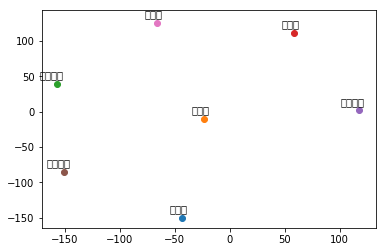

In [114]:
model = TSNE(learning_rate=100)
transformed = model.fit_transform(embedding_matrix)

xs = transformed[:,0]
ys = transformed[:,1]

for i, offset in enumerate(transformed[1:]):
    x, y = offset
    plt.scatter(x, y)
    plt.annotate(index_to_word[i+1], xy=(x, y), xytext=(6, 4),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()

In [117]:
import matplotlib.font_manager as fm  

In [118]:
font_path = '/content/gdrive/My Drive/asset/font/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=12)

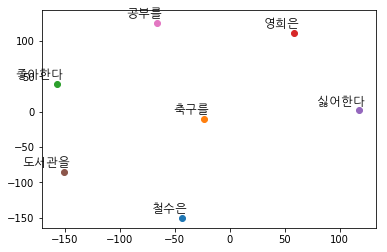

In [120]:
xs = transformed[:,0]
ys = transformed[:,1]

for i, offset in enumerate(transformed[1:]):
    x, y = offset
    plt.scatter(x, y)
    plt.annotate(index_to_word[i+1], xy=(x, y), xytext=(6, 4),
                 textcoords='offset points', ha='right', va='bottom', fontproperties=fontprop)

plt.show()